In [1]:
#Installing packages and loading them into the enviroment
install.packages("MASS")
library("MASS")
install.packages("missMDA")
library("missMDA")
install.packages("tidyverse")
library("tidyverse")
install.packages("caret")
library("caret")
install.packages("mice")
library("mice")
install.packages("viridis")
library("viridis")
install.packages("ggrepel")
library("ggrepel")
install.packages("pROC")
library("pROC")

package 'MASS' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\daeda\AppData\Local\Temp\Rtmpm8jqa1\downloaded_packages


Warning message:
"package 'MASS' was built under R version 4.0.5"


package 'missMDA' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\daeda\AppData\Local\Temp\Rtmpm8jqa1\downloaded_packages


Warning message:
"package 'missMDA' was built under R version 4.0.5"


package 'tidyverse' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\daeda\AppData\Local\Temp\Rtmpm8jqa1\downloaded_packages


Warning message:
"package 'tidyverse' was built under R version 4.0.5"
-- Attaching packages --------------------------------------- tidyverse 1.3.0 --

v ggplot2 3.3.3     v purrr   0.3.4
v tibble  3.0.3     v dplyr   1.0.2
v tidyr   1.1.2     v stringr 1.4.0
v readr   1.3.1     v forcats 0.5.0

Warning message:
"package 'ggplot2' was built under R version 4.0.5"
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
x dplyr::select() masks MASS::select()



package 'caret' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\daeda\AppData\Local\Temp\Rtmpm8jqa1\downloaded_packages


Warning message:
"package 'caret' was built under R version 4.0.5"
Loading required package: lattice


Attaching package: 'caret'


The following object is masked from 'package:purrr':

    lift




package 'mice' successfully unpacked and MD5 sums checked


Warning message:
"cannot remove prior installation of package 'mice'"
Warning message in file.copy(savedcopy, lib, recursive = TRUE):
"problem copying D:\R\library\00LOCK\mice\libs\x64\mice.dll to D:\R\library\mice\libs\x64\mice.dll: Permission denied"
Warning message:
"restored 'mice'"



The downloaded binary packages are in
	C:\Users\daeda\AppData\Local\Temp\Rtmpm8jqa1\downloaded_packages



Attaching package: 'mice'


The following objects are masked from 'package:base':

    cbind, rbind




package 'viridis' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\daeda\AppData\Local\Temp\Rtmpm8jqa1\downloaded_packages


Warning message:
"package 'viridis' was built under R version 4.0.5"
Loading required package: viridisLite



package 'ggrepel' successfully unpacked and MD5 sums checked


Warning message:
"cannot remove prior installation of package 'ggrepel'"
Warning message in file.copy(savedcopy, lib, recursive = TRUE):
"problem copying D:\R\library\00LOCK\ggrepel\libs\x64\ggrepel.dll to D:\R\library\ggrepel\libs\x64\ggrepel.dll: Permission denied"
Warning message:
"restored 'ggrepel'"



The downloaded binary packages are in
	C:\Users\daeda\AppData\Local\Temp\Rtmpm8jqa1\downloaded_packages
package 'pROC' successfully unpacked and MD5 sums checked


Warning message:
"cannot remove prior installation of package 'pROC'"
Warning message in file.copy(savedcopy, lib, recursive = TRUE):
"problem copying D:\R\library\00LOCK\pROC\libs\x64\pROC.dll to D:\R\library\pROC\libs\x64\pROC.dll: Permission denied"
Warning message:
"restored 'pROC'"



The downloaded binary packages are in
	C:\Users\daeda\AppData\Local\Temp\Rtmpm8jqa1\downloaded_packages


Type 'citation("pROC")' for a citation.


Attaching package: 'pROC'


The following objects are masked from 'package:stats':

    cov, smooth, var




In [2]:
#Loading all needed files,dropping first two coloumns, which are not needed for analysis (ID, species)
ionomics <- read.csv('spec_woAestAcerPalmVulp_shoot_xyz_concat.csv', colClasses =c("NULL","NULL",NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,
                                                                    NA,NA,NA,NA,NA,NA,NA))
hybrids <- read.csv('spec_shoot_xyz_concat_unk_only.csv', colClasses = c("NULL",NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,
                                                                        NA,NA,NA,NA,NA,NA,NA))
#Imputation via missMDA
imputeIonomics <- imputePCA(ionomics, method = "Regularized")

In [3]:
#Imputation via Mice
# TODO add in fit graphics and missing data quantification
temp <- mice(ionomics, m = 1, maxit = 5, method = "norm.boot", seed = 567)
ionomicsComplete <- complete(temp,1)


 iter imp variable
  1   1  S34_X
  2   1  S34_X
  3   1  S34_X
  4   1  S34_X
  5   1  S34_X


In [4]:
#data imputed with missMDA regularized method
mean.impute <- 0 #Start our average with 0
auc <- 0
for (x in 1:1000){ # run 1000 permutations
    set.seed(x) #cycle through many random generator seeds
    training.samples.impute <- imputeIonomics$completeObs[,2] %>%
        createDataPartition(p = 0.8, list = FALSE) #split the data into training (80%) and testing (20%)
    train.data.impute <- imputeIonomics$completeObs[training.samples.impute, ] #generate training set
    test.data.impute <- imputeIonomics$completeObs[-training.samples.impute, ] #generate test set
    train.data.impute <- unlist(train.data.impute) #typecast from matrix into dataframe
    test.data.impute <- unlist(test.data.impute)
    train.data.impute <- as.data.frame(train.data.impute)
    test.data.impute <- as.data.frame(test.data.impute)
    model.impute <- lda(spec_as_int~., data = train.data.impute) #generate the LDA model
    predictions.impute <- model.impute %>% predict(test.data.impute) #predict the species of individuals in our test set based off of this model
    mean.impute = mean.impute + mean(predictions.impute$class==test.data.impute$spec_as_int) #measure how often this prediction is correct, then add it to a running total
    m.roc <- multiclass.roc(test.data.impute$spec_as_int, as.numeric(predictions.impute$class), direction = "<") #measures area under the curve for classifier metric accuracy
    auc <- auc + m.roc$auc
}
mean.impute = mean.impute/999 #divide running total by number of runs to find our average LDA model accuracy
auc <- auc/999 #divide running total by number of runs to find our average AUC accuracy
auc #print the AUC average to the screen
mean.impute #print the LDA model average to the screen

Multi-class area under the curve: 0.869

[1] 0.8551051

In [5]:
#data imputed with mice, norm.boot method
mean.mice = 0 #Start our average with 0
auc = 0
for (x in 1:1000){ #run 10000 permutations
    set.seed(x)  #cycle through many random generator seeds
    training.samples.mice <- ionomicsComplete[,2] %>%
        createDataPartition(p = 0.8, list = FALSE) #split the data into training (80%) and testing (20%)
    train.data.mice <- ionomicsComplete[training.samples.mice, ] #generate training set
    test.data.mice <- ionomicsComplete[-training.samples.mice, ] #generate test set
    model.mice <- lda(spec_as_int~., data = train.data.mice) #generate the LDA model
    predictions.mice <- model.mice %>% predict(test.data.mice) #predict the species of individuals in our test set based off of this model
    mean.mice = mean.mice + mean(predictions.mice$class==test.data.mice$spec_as_int) #measure how often this prediction is correct, then add it to a running total
    m.roc <- multiclass.roc(test.data.mice$spec_as_int, as.numeric(predictions.mice$class), direction = "<") #measures area under the curve for classifier metric accuracy
    auc <- auc + m.roc$auc
}
mean.mice = mean.mice/999 #divide running total by number of runs to find our average
auc <- auc/999 #divide running total by number of runs to find our average AUC accuracy
auc #print the AUC average to the screen
mean.mice #print the LDA average to the screen

Multi-class area under the curve: 0.8694

[1] 0.8553241

In [6]:
df.impute <- as.data.frame(unlist(imputeIonomics$completeObs))
lda.impute <- lda(spec_as_int~., data = df.impute)
pred.impute <- predict(lda.impute)
pred.hybrids <- lda.impute %>% predict(hybrids)

In [7]:
viz.impute <- data.frame(spec = df.impute[1], lda = pred.impute$x)
viz.hybrids <- data.frame(spec = hybrids[2], lda = pred.hybrids$x)
viz.impute$spec = as.factor(viz.impute$spec)
viz.hybrids$spec = as.factor(viz.hybrids$spec)
row.names(viz.hybrids) = unlist(hybrids[1])
viz.hybrids

,spec_as_int,lda.LD1,lda.LD2,lda.LD3,spec
,<int>,<dbl>,<dbl>,<dbl>,<fct>
V._candicans_or_hybrid,30,-0.5297356188,0.5662986,-0.6094765,30
V._spp._a,31,4.7966376981,-1.8711273,-4.7490031,31
V._spp._b,32,2.6727379078,1.9157437,0.7359220,32
V._spp._c,33,0.0003084282,-1.8734644,0.2504446,33
V._spp._d,34,-3.0909011097,-9.7387830,-7.9806505,34
V._spp._e,35,0.6141437703,-2.3911309,-2.3673606,35
V._spp._f,36,0.6043256165,-2.2506934,-2.0678278,36
V._spp._g,37,0.1127374252,-2.1494215,-1.9994755,37
Vitis × V. andersonii,38,1.8717464316,-0.3228269,-0.2046044,38


Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.

Saving 6.67 x 6.67 in image



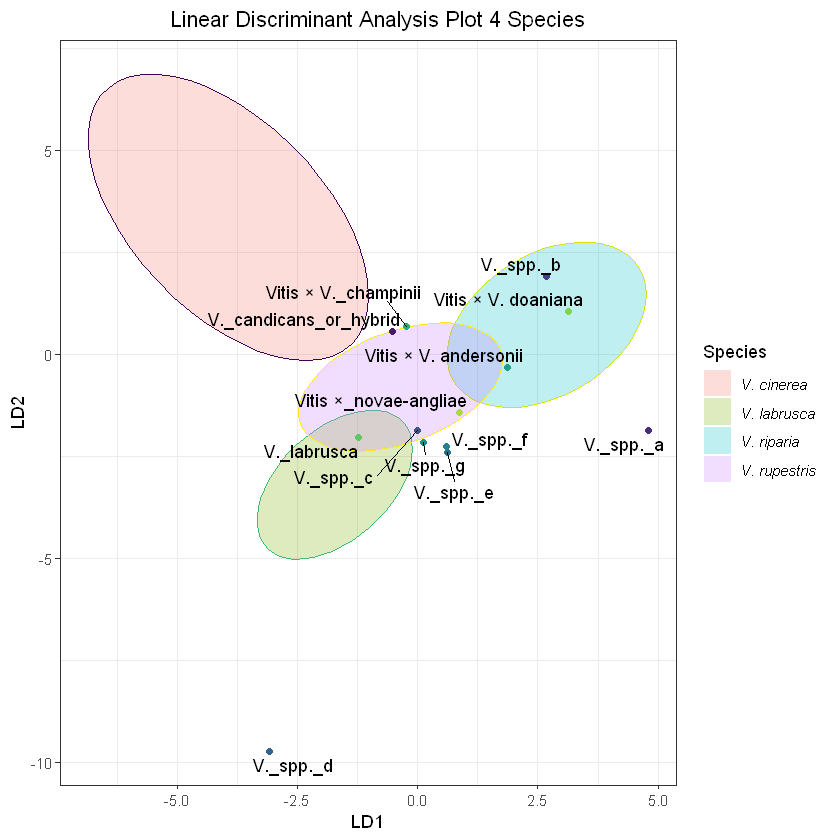

In [9]:
p <- ggplot(data = NULL) + 
    stat_ellipse(data = viz.impute, 
    aes(x = lda.LD1, y = lda.LD2, color = spec, fill = spec),geom = "polygon", alpha = .25)+
    geom_point(data = viz.hybrids, aes(x = lda.LD1, y = lda.LD2, color = spec))
p <- p + scale_color_viridis_d(aesthetics = "fill")
p <- p + scale_color_viridis_d(aesthetics = "color")
p <- p + theme_bw()
p <- p + xlab("LD1")
p <- p + ylab("LD2")
p <- p + labs(title = "Linear Discriminant Analysis Plot 4 Species")
p <- p + theme(plot.title = element_text(hjust = .55), legend.text = element_text(face = "italic"))
p <- p + scale_fill_discrete(name = "Species", labels = c("V. cinerea","V. labrusca","V. riparia","V. rupestris"))
p <- p + guides(color = FALSE)
p <- p + geom_text_repel(aes(x = viz.hybrids$lda.LD1, y = viz.hybrids$lda.LD2), label = rownames(viz.hybrids), vjust = "inward",
                 hjust = "inward")
p
ggsave(filename = "LDA_Four.jpg", dpi = "retina")

|species|spec_as_int|
|---|---|
|cinerea_x|3|
|labrusca_x|4|
|riparia_x|6|
|rupestris_x|7|

In [11]:
#mice data
confusionMatrix( data=as.factor(predictions.mice$class), reference = as.factor(test.data.mice$spec_as_int), dnn = c("Prediction", "Reference"), prevalence = NULL, mode="everything")

Confusion Matrix and Statistics

          Reference
Prediction  3  4  6  7
         3  4  0  0  0
         4  0  7  1  1
         6  0  0 10  0
         7  0  0  0  9

Overall Statistics
                                          
               Accuracy : 0.9375          
                 95% CI : (0.7919, 0.9923)
    No Information Rate : 0.3438          
    P-Value [Acc > NIR] : 2.701e-12       
                                          
                  Kappa : 0.9141          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: 3 Class: 4 Class: 6 Class: 7
Sensitivity             1.000   1.0000   0.9091   0.9000
Specificity             1.000   0.9200   1.0000   1.0000
Pos Pred Value          1.000   0.7778   1.0000   1.0000
Neg Pred Value          1.000   1.0000   0.9545   0.9565
Precision               1.000   0.7778   1.0000   1.0000
Recall                  1.000   1.0000   0.9091   0.9000
F1 

In [12]:
#missMDA data
confusionMatrix( data=as.factor(predictions.impute$class), reference = as.factor(test.data.impute$spec_as_int), dnn = c("Prediction", "Reference"), prevalence = NULL, mode="everything")

Confusion Matrix and Statistics

          Reference
Prediction  3  4  6  7
         3  4  0  0  0
         4  0  7  1  1
         6  0  0 10  0
         7  0  0  0  9

Overall Statistics
                                          
               Accuracy : 0.9375          
                 95% CI : (0.7919, 0.9923)
    No Information Rate : 0.3438          
    P-Value [Acc > NIR] : 2.701e-12       
                                          
                  Kappa : 0.9141          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: 3 Class: 4 Class: 6 Class: 7
Sensitivity             1.000   1.0000   0.9091   0.9000
Specificity             1.000   0.9200   1.0000   1.0000
Pos Pred Value          1.000   0.7778   1.0000   1.0000
Neg Pred Value          1.000   1.0000   0.9545   0.9565
Precision               1.000   0.7778   1.0000   1.0000
Recall                  1.000   1.0000   0.9091   0.9000
F1 